In [2]:
import os
ROOT_PATH = "/home/maelic/Documents/PhD/MyModel/Scene-Graph-Benchmark-Cuda11.7"

eval_path = "checkpoints/original_VG150/upload_causal_motif_sgdet/inference/VG_stanford_filtered_with_attribute_test/eval_results.pytorch"
eval_path = "/home/maelic/Documents/PhD/MyModel/Scene-Graph-Benchmark-Cuda11.7/checkpoints/original_VG150/upload_causal_motif_sgdet/inference/VG_stanford_filtered_with_attribute_test/eval_results.pytorch"

# load eval results
import torch
eval_results = torch.load(eval_path)

# load categories
import csv
cat = "/home/maelic/Documents/PhD/MyModel/PhD_Commonsense_Enrichment/VG_refinement/category_classification/vg150_classification/categories_gpt3.5_vg150_2.csv"
categories = {}
with open(cat, newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',')
    for row in spamreader:
        categories[row[0]] = row[1]

vg_dict = "/home/maelic/Documents/PhD/MyModel/Scene-Graph-Benchmark-Cuda11.7/datasets/vg/VG-SGG-dicts-with-attri.json"

import json
with open(vg_dict) as f:
    vg_dict = json.load(f)

PRED_CLASSES = vg_dict['idx_to_predicate']
OBJ_CLASSES = vg_dict['idx_to_label']

In [5]:
print(str(eval_results['predictions'][0].fields()))


['pred_labels', 'pred_scores', 'rel_pair_idxs', 'pred_rel_scores', 'pred_rel_labels']


100%|██████████| 13223/13223 [12:41<00:00, 17.36it/s]

{'topological': 0.5996747090112952, 'functional': 0.05582524152260002, 'part-whole': 0.17771886574460247, 'attribute': 0.09365103171363728}


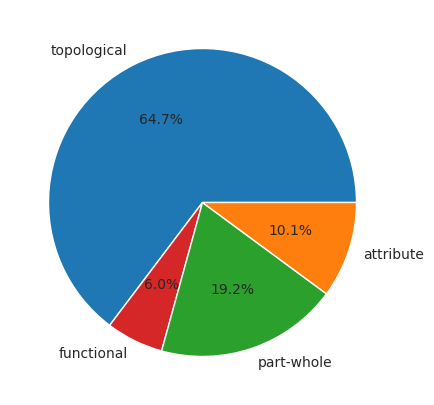

In [10]:
# print(str(eval_results['predictions'][0].fields()))
import numpy as np
from tqdm import tqdm

cat_counter = {'topological': 0, 'functional': 0, 'part-whole': 0, 'attribute': 0}
cat_list = []
per_img_distri = {'topological': [], 'functional': [], 'part-whole': [], 'attribute': []}

for img in tqdm(eval_results['predictions']):
    # keep only top 20 predicates by score
    pred_rel_scores = img.get_field('pred_rel_scores').tolist()
    pred_rel_labels = img.get_field('pred_rel_labels').tolist()
    pair_idx = img.get_field('rel_pair_idxs').tolist()

    # sort the 3 list by pred_rel_scores
    sorted_scoreidx = sorted([(s, i) for i, s in enumerate(pred_rel_scores)], reverse=True)
    sorted2id = [item[1] for item in sorted_scoreidx][:100]
    id2sorted = [item[1] for item in sorted([(j,i) for i, j in enumerate(sorted2id)])]

    for k, v in per_img_distri.items():
        v.append(0)

    num = 0

    for i in sorted2id:
        rel = pred_rel_labels[i]
        pair = pair_idx[i]
        obj = OBJ_CLASSES[str(img.get_field('pred_labels').tolist()[pair[0]])]
        subj = OBJ_CLASSES[str(img.get_field('pred_labels').tolist()[pair[1]])]
        triplet = obj + " " + PRED_CLASSES[str(rel)] + " " + subj

        if triplet in categories.keys():
            cat_counter[categories[triplet]] += 1
            cat_list.append(categories[triplet])
            per_img_distri[categories[triplet]][-1] += 1
            num += 1
        
    for k, v in per_img_distri.items():
        if num == 0:
            per_img_distri[k][-1] = 0
        else:
            per_img_distri[k][-1] = per_img_distri[k][-1]/num

# labels = cat_counter.keys()
# sizes = cat_counter.values()
# explode = (0, 0, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

# fig1, ax1 = plt.subplots(figsize=(10, 10))
# ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
#         shadow=False, startangle=90, textprops={'fontsize': 20})
# ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# plt.show()

# average distri across images
for k, v in per_img_distri.items():
    per_img_distri[k] = np.mean(v)

# Plot
print(per_img_distri)
# plot as a pie chart
import matplotlib.pyplot as plt
c_dict = {'functional': '#d62728', 'topological': '#1f77b4', 'part-whole': '#2ca02c', 'attribute': '#ff7f0e'}
colors = [c_dict[x] for x in per_img_distri.keys()]
plt.figure(figsize=(5,5))
plt.pie(per_img_distri.values(), labels=per_img_distri.keys(), autopct='%1.1f%%', colors=colors)
plt.show()

In [8]:
print(len(cat_list))
print(len(eval_results['predictions'])*20)

print(len(cat_list)/(len(eval_results['predictions'])*20))

13218
264460
0.04998109354911896


<Axes: ylabel='count'>

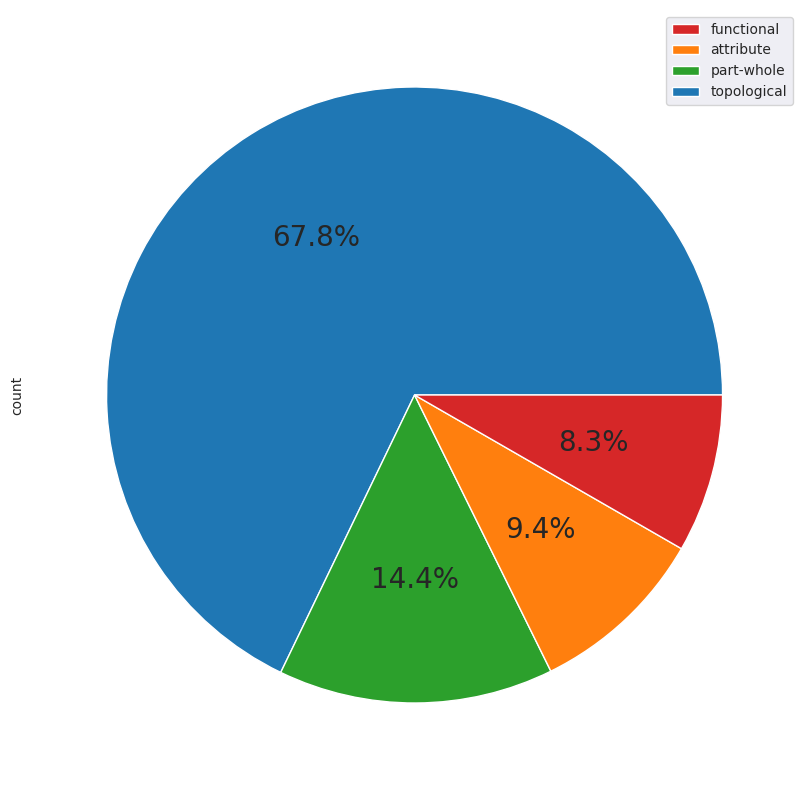

In [9]:
import pandas as pd 
df = pd.DataFrame(cat_list, columns=['category'])

import seaborn as sns
sns.set_style("dark")

import matplotlib.pyplot as plt
import numpy as np
# display dataframe as a pie chart but don't show labels
c_dict = {'functional': '#d62728', 'topological': '#1f77b4', 'part-whole': '#2ca02c', 'attribute': '#ff7f0e'}
colors = [c_dict[x] for x in df['category'].value_counts().index]
df['category'].value_counts().plot(kind='pie', colors=colors, autopct='%1.1f%%', figsize=(10, 10), textprops={'fontsize': 20}, legend='reverse',labels=None)